In [127]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# Set up and design project

In [18]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [19]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [20]:
%%time
DLC_social_1 = project(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                   smooth_alpha=0.15,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego='B_Center',
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.72 s, sys: 864 ms, total: 3.58 s
Wall time: 1.61 s


# Run project

In [21]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9 s, sys: 966 ms, total: 9.96 s
Wall time: 13 s


source.classes.coordinates

# Generate coords

In [22]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0)
ptest._type

CPU times: user 795 ms, sys: 89 ms, total: 884 ms
Wall time: 871 ms


'coords'

In [23]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0)
dtest._type

CPU times: user 28.6 ms, sys: 17.6 ms, total: 46.2 ms
Wall time: 45.6 ms


'dists'

In [24]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0)
atest._type

CPU times: user 125 ms, sys: 82.2 ms, total: 208 ms
Wall time: 208 ms


'angles'

# Visualization playground

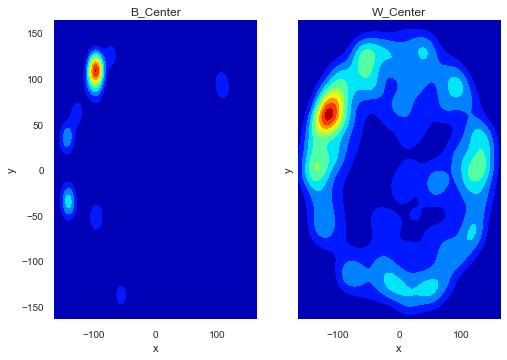

In [25]:
ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

# Dimensionality reduction playground

In [26]:
pca = ptest.pca(4, 1000)

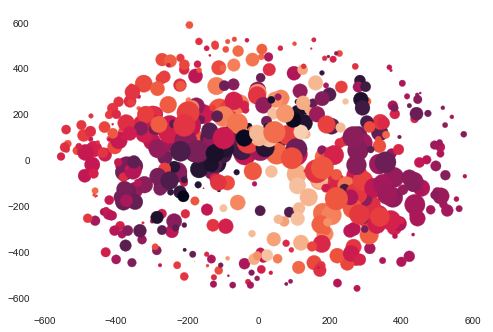

In [27]:
plt.scatter(*pca[0].T)
plt.show()

# Feature experiments playground

In [88]:
#Merging table_dict class

In [132]:
a = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True),
                 DLC_social_1_coords.get_coords(center=True, speed=1),
                 DLC_social_1_coords.get_coords(center=True, speed=2),
                 DLC_social_1_coords.get_distances(speed=0),
                 DLC_social_1_coords.get_distances(speed=1),
                 DLC_social_1_coords.get_distances(speed=2),
                 DLC_social_1_coords.get_angles(degrees=True, speed=0),
                 DLC_social_1_coords.get_angles(degrees=True, speed=1),
                 DLC_social_1_coords.get_angles(degrees=True, speed=2))

In [135]:
a.preprocess(window_size=50).shape

(704998, 50, 149)